<a href="https://colab.research.google.com/github/liangchow/soil-type-predictions/blob/main/soil_type_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up Worksheet and Import Libraries

In [1]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/soil-type-predictions.git

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'soil-type-predictions'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (31/31), 606.15 KiB | 4.56 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
# Acess to soil-type-preidctions folder
%cd /content/soil-type-predictions

# Import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils_log import *
from utils_plot import *

/content/soil-type-predictions


In [3]:
# Google Colab GPU
# Check if GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


# Read Data
The dataset should contains the following. There is a total of 126 soil samples:
- ID: Boring ID
- Depth: Depth (ft) the sample was taken
- Sampler: MCS = Modified California Sampler or SPT = Standard Penetration Test
- N1: Known as "set". First set of blowcount counted over first 6 inches of sampler
- N2: The second set of blowcount from 6 to 12 inches of the sampler
- N3: The third set of blowcount from 12 to 18 inches of the sampler
- Soil: Generic soil types "clay" or "sand"
- USCS: USCS soil classification if there is data available

In [4]:
# Read soil data
file_path = "./field_data/soil.csv"
df = pd.read_csv(file_path)
df

,ID,Depth,Sampler,N1,N2,N3,Soil,UCSC
0,B-1,15.0,MCS,0.0,0.0,0.0,Clay,CL
1,B-1,20.0,MCS,0.0,0.0,0.0,Clay,CL
2,B-1,75.0,SPT,0.0,3.0,2.0,Clay,CH
3,B-1,100.0,SPT,24.0,19.0,20.0,Clay,CL
4,B-2,10.5,MCS,0.0,0.0,0.0,Clay,CL
...,...,...,...,...,...,...,...,...
121,AB-4,25.0,SPT,6.0,9.0,16.0,Sand,ML
122,AB-4,35.0,SPT,25.0,35.0,39.0,Sand,SC
123,AB-4,40.0,SPT,16.0,28.0,25.0,Sand,SC
124,AB-4,45.0,SPT,8.0,11.0,20.0,Sand,SC


# Data Pre-Processing
Before we visualize the data, we will add two columns to the `dataframe()`. The first column will be "SPT-N" and the second column, "Class", will be categorizing Sand as "1" and Clay as "0". By definition, SPT-N is the summation of SPT blowcount from 6 to 18 inches, i.e., N2 + N3. Blowcount from the first 6 inches of sampler or "set" is considered as distrubed, and generally disregarded. However, for Modified California Sampler (MCS), a coverstion factor of 0.68 based on the area ratio is applied to the blowcount to get equivalent SPT-N.  

For simplicity, we will only group the soil type into two classes: Sand (y=1) and Clay (y=0). We will not use the USCS classifications in this exercise.

In [22]:
# Create a function to compute SPT-N
def calculate_SPT_N(sampler, n2, n3):
  n_val = n2 + n3

  if sampler == "MCS":
    return 0.68*n_val
  else:
    return n_val

# Create a function to categorize Sand and Clay
def categorize_soil(soil):
  if soil == "Sand":
    return 1
  else:
    return 0

In [23]:
# Apply calculate_SPT_N() to the dataframe().
df["SPT-N"] = df.apply(lambda x: calculate_SPT_N(x["Sampler"], x["N2"], x["N3"]), axis=1)
df["Class"] = df["Soil"].apply(lambda x: categorize_soil(x))
df

,ID,Depth,Sampler,N1,N2,N3,Soil,UCSC,SPT-N,Class
0,B-1,15.0,MCS,0.0,0.0,0.0,Clay,CL,0.0,0
1,B-1,20.0,MCS,0.0,0.0,0.0,Clay,CL,0.0,0
2,B-1,75.0,SPT,0.0,3.0,2.0,Clay,CH,5.0,0
3,B-1,100.0,SPT,24.0,19.0,20.0,Clay,CL,39.0,0
4,B-2,10.5,MCS,0.0,0.0,0.0,Clay,CL,0.0,0
...,...,...,...,...,...,...,...,...,...,...
121,AB-4,25.0,SPT,6.0,9.0,16.0,Sand,ML,25.0,1
122,AB-4,35.0,SPT,25.0,35.0,39.0,Sand,SC,74.0,1
123,AB-4,40.0,SPT,16.0,28.0,25.0,Sand,SC,53.0,1
124,AB-4,45.0,SPT,8.0,11.0,20.0,Sand,SC,31.0,1


# Data Visualization
Let's take a look at the data: The upper plot is for Clay (y=0) and the lower is for Sand (y=1). When SPT-N is plotted against depths, we see two clusters of data. Clay data points tend to skew toward lower blowcount, while Sand data points spread across the range from 0 to 200. This is great because we can draw a boundary line between these two clusters.

Class
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
dtype: object

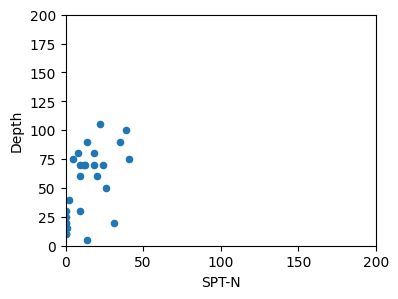

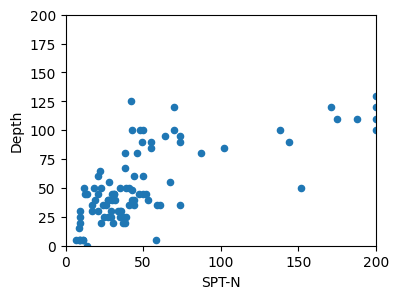

In [24]:
# Plotting two classes: Clay and Sand
df.groupby("Class").plot(kind='scatter', x='SPT-N', y='Depth', xlim=(0, 200), ylim=(0,200), figsize=(4,3))

# Data Processing

In [ ]:
# Separate data into X_train and y_train
X_train = df[["Depth", "SPT-N"]]
y_train = df["Soil"]

Date           0
Water_Elev    38
dtype: int64